# Problem Statement
This data is for the purpose of bias correction of next-day maximum and minimum air temperatures forecast of the LDAPS model operated by the Korea Meteorological Administration over Seoul, South Korea. This data consists of summer data from 2013 to 2017. The input data is largely composed of the LDAPS model's next-day forecast data, in-situ maximum and minimum temperatures of present-day, and geographic auxiliary variables. There are two outputs (i.e. next-day maximum and minimum air temperatures) in this data. Hindcast validation was conducted for the period from 2015 to 2017.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression , Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
temp_ds = pd.read_csv("Temprature.csv")
temp_ds.sample(5)

,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
4140,16.0,10-08-2015,30.0,22.4,43.947239,94.621895,31.099741,23.885999,5.426762,89.102840,...,0.000000,0.0,0.00000,37.4697,126.995,82.2912,2.2579,5124.781250,30.0,22.4
996,22.0,08-08-2013,33.9,27.3,78.708603,91.888855,30.535538,28.037949,8.367896,64.973928,...,0.392801,0.0,0.00000,37.5102,127.086,21.9668,0.1332,5200.162598,33.1,27.0
4846,22.0,07-07-2016,28.6,21.4,46.403713,86.645035,32.208835,22.965259,4.855189,70.278257,...,0.000000,0.0,0.00000,37.5102,127.086,21.9668,0.1332,5793.305176,33.0,21.9
3477,3.0,15-07-2015,34.2,22.4,37.176437,66.463325,29.663437,21.421694,12.198275,19.957174,...,0.000000,0.0,0.00000,37.5776,127.058,33.3068,0.2661,5721.618652,27.9,20.2
5492,18.0,02-08-2016,32.0,23.8,55.956024,93.595390,32.426253,24.134043,5.245513,96.237509,...,0.000000,0.0,0.33888,37.4832,127.024,56.4448,1.2313,5339.032227,36.0,25.0


In [3]:
temp_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7752 entries, 0 to 7751
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station           7750 non-null   float64
 1   Date              7750 non-null   object 
 2   Present_Tmax      7682 non-null   float64
 3   Present_Tmin      7682 non-null   float64
 4   LDAPS_RHmin       7677 non-null   float64
 5   LDAPS_RHmax       7677 non-null   float64
 6   LDAPS_Tmax_lapse  7677 non-null   float64
 7   LDAPS_Tmin_lapse  7677 non-null   float64
 8   LDAPS_WS          7677 non-null   float64
 9   LDAPS_LH          7677 non-null   float64
 10  LDAPS_CC1         7677 non-null   float64
 11  LDAPS_CC2         7677 non-null   float64
 12  LDAPS_CC3         7677 non-null   float64
 13  LDAPS_CC4         7677 non-null   float64
 14  LDAPS_PPT1        7677 non-null   float64
 15  LDAPS_PPT2        7677 non-null   float64
 16  LDAPS_PPT3        7677 non-null   float64


In [4]:
# changing the datatype of date column 

# temp_ds["Date"] = pd.to_datetime(temp_ds["Date"])

In [5]:
# checking the missing values

def mising_val(x):
    missing_value = {}
    for i in x.columns:
        if x[i].isnull().sum() >0:
            missing_value[i] = x[i].isnull().sum()
    print(missing_value)

In [6]:
mising_val(temp_ds)

{'station': 2, 'Date': 2, 'Present_Tmax': 70, 'Present_Tmin': 70, 'LDAPS_RHmin': 75, 'LDAPS_RHmax': 75, 'LDAPS_Tmax_lapse': 75, 'LDAPS_Tmin_lapse': 75, 'LDAPS_WS': 75, 'LDAPS_LH': 75, 'LDAPS_CC1': 75, 'LDAPS_CC2': 75, 'LDAPS_CC3': 75, 'LDAPS_CC4': 75, 'LDAPS_PPT1': 75, 'LDAPS_PPT2': 75, 'LDAPS_PPT3': 75, 'LDAPS_PPT4': 75, 'Next_Tmax': 27, 'Next_Tmin': 27}


Every columns has missing values min missing values count are and max 75. looking at the stats we will fill them 

In [7]:
temp_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
station,7750.0,13.000000,7.211568,1.000000,7.000000,13.000000,19.000000,25.000000
Present_Tmax,7682.0,29.768211,2.969999,20.000000,27.800000,29.900000,32.000000,37.600000
Present_Tmin,7682.0,23.225059,2.413961,11.300000,21.700000,23.400000,24.900000,29.900000
LDAPS_RHmin,7677.0,56.759372,14.668111,19.794666,45.963543,55.039024,67.190056,98.524734
LDAPS_RHmax,7677.0,88.374804,7.192004,58.936283,84.222862,89.793480,93.743629,100.000153
LDAPS_Tmax_lapse,7677.0,29.613447,2.947191,17.624954,27.673499,29.703426,31.710450,38.542255
LDAPS_Tmin_lapse,7677.0,23.512589,2.345347,14.272646,22.089739,23.760199,25.152909,29.619342
LDAPS_WS,7677.0,7.097875,2.183836,2.882580,5.678705,6.547470,8.032276,21.857621
LDAPS_LH,7677.0,62.505019,33.730589,-13.603212,37.266753,56.865482,84.223616,213.414006
LDAPS_CC1,7677.0,0.368774,0.262458,0.000000,0.146654,0.315697,0.575489,0.967277


1. It has been observed that some column has high spread and some of the columns's std is close to mean like present_Tmax has low standard deviation and some of the columns have high spread like LDAPS_LH.
2. we have seen couple of columns have 0 min value, median and 25th Percentile 
3. i have notice that ION is quasi constant columns, will check more and drop if they will be found constant
4. We have missing value in target columns also, we wil impute them wiht mean as max values comes under 3rd standard deviation hence for extreme values

# Filling Missing value

In [8]:
# we will fill station and date with mode as station is a categorical type and date is datetime and rest all will be filled with mean

temp_ds["station"] =  temp_ds["station"].fillna(temp_ds["station"].mode()[0])
temp_ds["Date"] = temp_ds["Date"].fillna(temp_ds["Date"].mode()[0])

# filling other columns

for i in temp_ds.iloc[:,2::].columns:
    temp_ds[i] = temp_ds[i].fillna(temp_ds[i].mean())
    
"""
we have imputed station and date columns with mode since they are categorical in nature.

other columns have been imputed with mean. columns are now free from missing value

"""    


'\nwe have imputed station and date columns with mode since they are categorical in nature.\n\nother columns have been imputed with mean. columns are now free from missing value\n\n'

In [9]:
mising_val(temp_ds)

{}


# EDA
# Univariate analysis

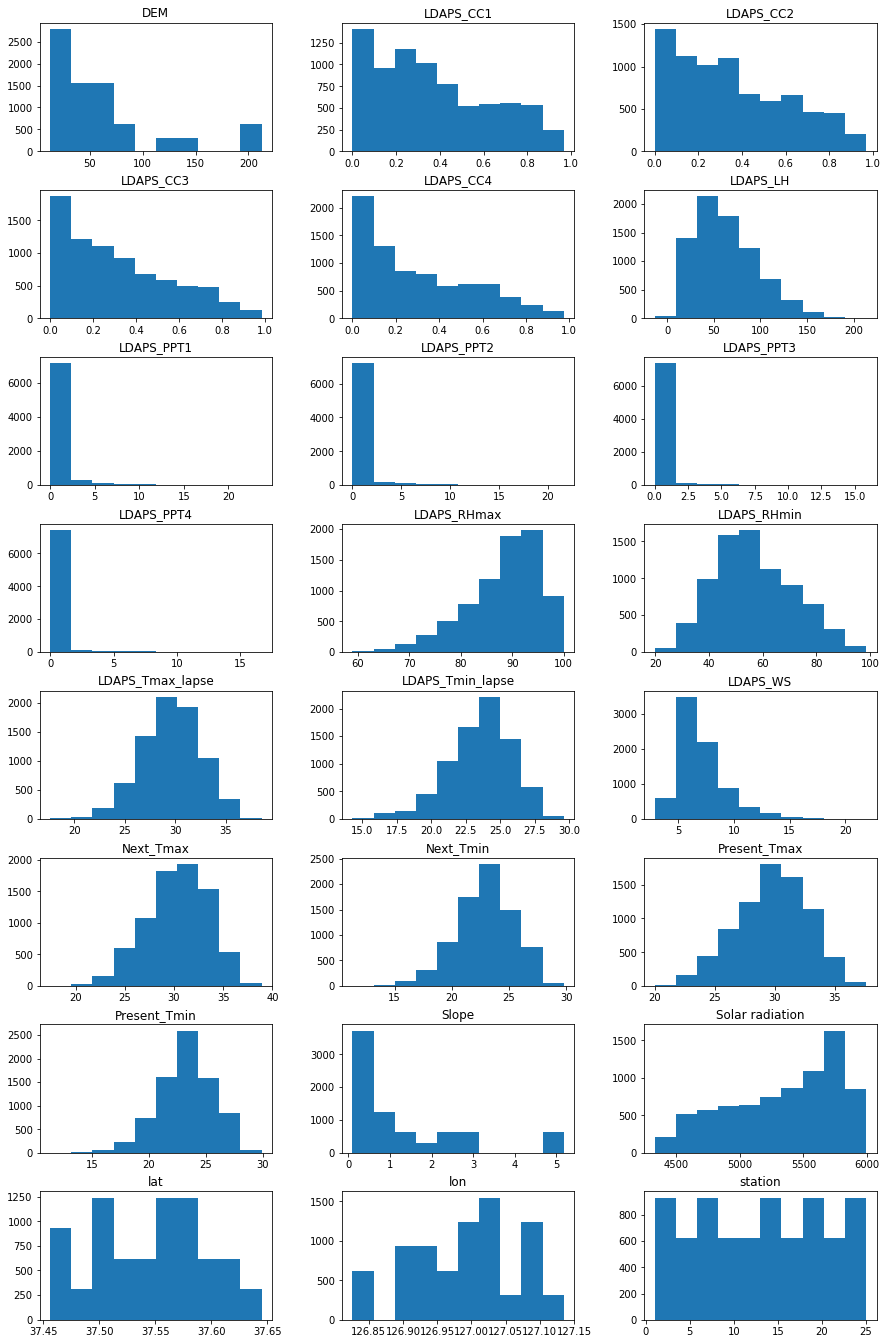

In [10]:
temp_ds.hist(figsize = (15,30), layout=(10,3), grid=False);

present TMIN and TMAX are close to normal distribution and rest are all skewed, we will check the skewness and correct them

In [11]:
very_low_scale =[] 
for i in temp_ds.iloc[:,2::].columns:
    if temp_ds[i].max() <1:
        very_low_scale.append(temp_ds[i])

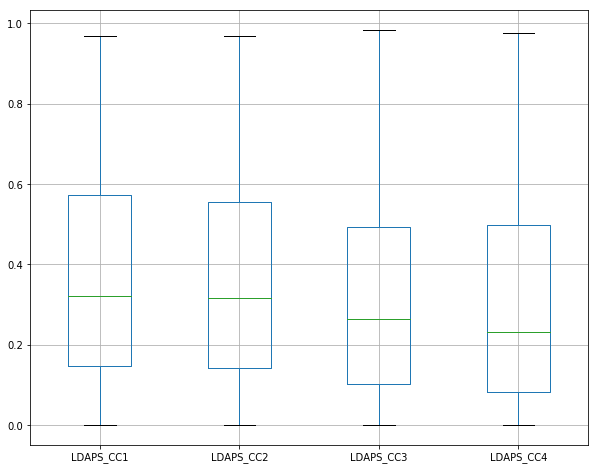

In [12]:
very_low_scale = pd.DataFrame(very_low_scale)
very_low_scale = very_low_scale.T
very_low_scale.boxplot(figsize = (10,8), grid = True)

These features dont have outliers 

In [13]:
scale =[] 
for i in temp_ds.iloc[:,2::].columns:
    if temp_ds[i].max() >1 and temp_ds[i].max() <20:
        scale.append(temp_ds[i])

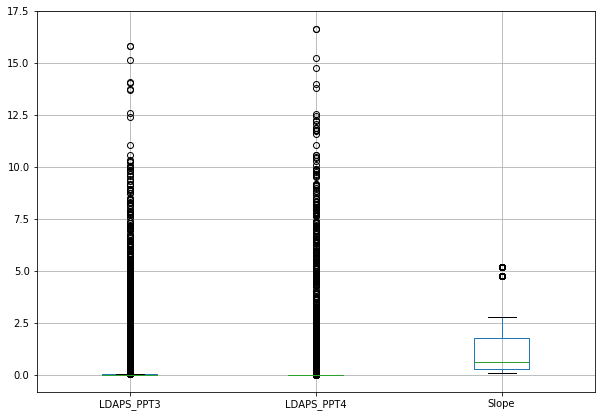

In [14]:
scale = pd.DataFrame(scale)
scale = scale.T
scale.boxplot(figsize = (10,7), grid = True)

we see outliers in these features 

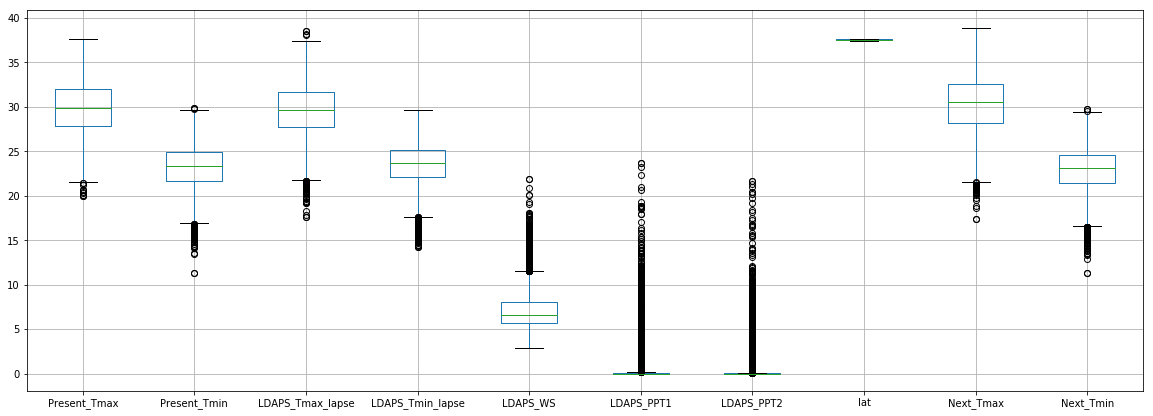

In [15]:
scale =[] 
for i in temp_ds.iloc[:,2::].columns:
    if temp_ds[i].max() >20 and temp_ds[i].max() <40:
        scale.append(temp_ds[i])
scale = pd.DataFrame(scale)
scale = scale.T
scale.boxplot(figsize = (20,7), grid = True)

we have outliers in all these features here as well except day 

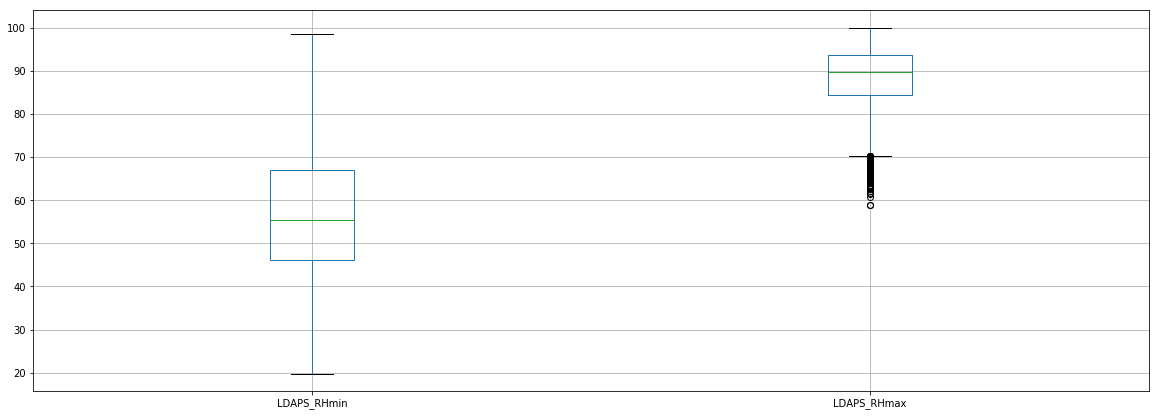

In [16]:
scale =[] 
for i in temp_ds.iloc[:,2::].columns:
    if temp_ds[i].max() > 80 and temp_ds[i].max() <120:
        scale.append(temp_ds[i])
scale = pd.DataFrame(scale)
scale = scale.T
scale.boxplot(figsize = (20,7), grid = True)

we have outlier in LDAPS_RHmax

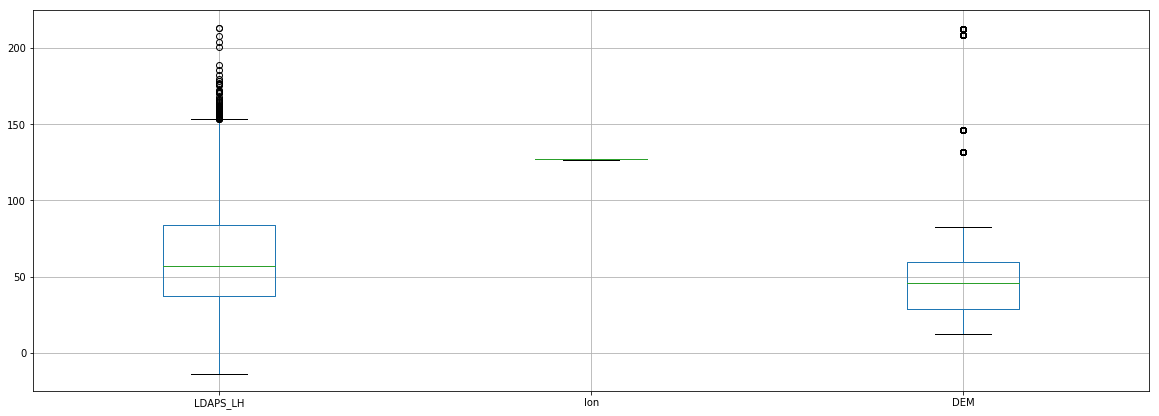

In [17]:
scale =[] 
for i in temp_ds.iloc[:,2::].columns:
    if temp_ds[i].max() > 120 and temp_ds[i].max() <250:
        scale.append(temp_ds[i])
scale = pd.DataFrame(scale)
scale = scale.T
scale.boxplot(figsize = (20,7), grid = True)

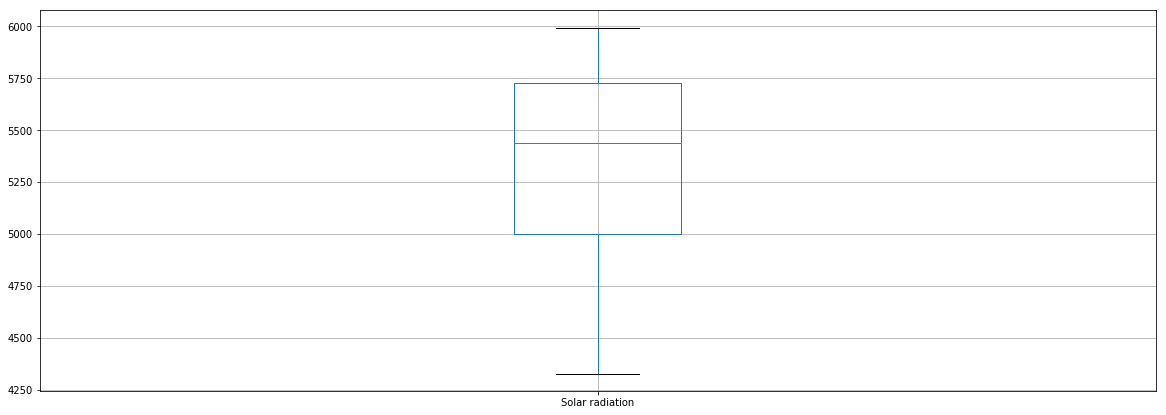

In [18]:
scale =[] 
for i in temp_ds.iloc[:,2::].columns:
    if temp_ds[i].max() > 250: 
        scale.append(temp_ds[i])
scale = pd.DataFrame(scale)
scale = scale.T
scale.boxplot(figsize = (20,7), grid = True)

we have seen that maximum features have outliers values, we will cap all of them with lower and upper bound

In [19]:
# Taking the date , month and year from date columns for further analysis
# change dtypes of date first 
temp_ds["Date"] = pd.to_datetime(temp_ds["Date"])

"""
extracting day, month and year from date and saving the into other columns and then deleting the date column 
"""
temp_ds["Day"] =  temp_ds["Date"].dt.day
temp_ds["Month"] =  temp_ds["Date"].dt.month
temp_ds["year"] =  temp_ds["Date"].dt.year

temp_ds.drop("Date",axis =1, inplace = True)

# Capping outlier

In [20]:
def find_cap_outlier_std(x,i):
    mean = x[i].mean()
    SD =  x[i].std()
        
    upper_bound = mean + (3*SD)
    lower_bound = mean - (3*SD)
    x[i] = np.where(x[i]>upper_bound,upper_bound, np.where(x[i] < lower_bound ,lower_bound ,x[i]))
        

In [21]:
"""capping outlier with these feature with 3rd standard deviation as these 25th percetile is 0 and 
all values go in minus by applying IQR method and capping other columns also with same method"""

find_cap_outlier_std(temp_ds,"LDAPS_PPT4")
find_cap_outlier_std(temp_ds,"LDAPS_PPT3")
find_cap_outlier_std(temp_ds,"LDAPS_PPT1")
find_cap_outlier_std(temp_ds,"LDAPS_PPT2")
find_cap_outlier_std(temp_ds,"Slope")
find_cap_outlier_std(temp_ds,"Present_Tmax")
find_cap_outlier_std(temp_ds,"Present_Tmin")
find_cap_outlier_std(temp_ds,"LDAPS_Tmax_lapse")
find_cap_outlier_std(temp_ds,"LDAPS_Tmin_lapse")
find_cap_outlier_std(temp_ds,"LDAPS_WS")
find_cap_outlier_std(temp_ds,"LDAPS_RHmax")
find_cap_outlier_std(temp_ds,"LDAPS_LH")
find_cap_outlier_std(temp_ds,"DEM")

In [22]:
temp_ds2 = temp_ds.copy()  # copying data into another variable

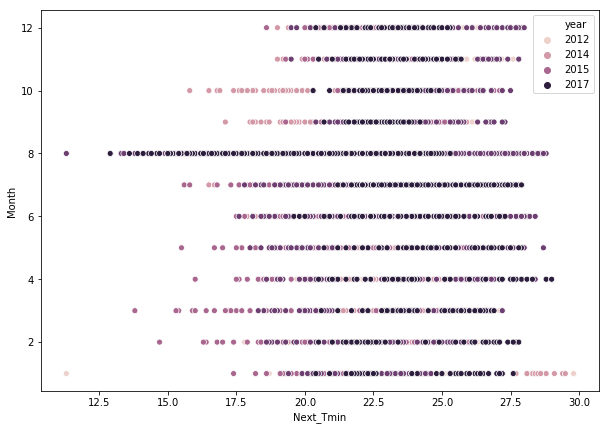

In [23]:
plt.figure(figsize =(10,7))
sns.scatterplot(x = "Next_Tmin",y = "Month", data = temp_ds, hue = "year")

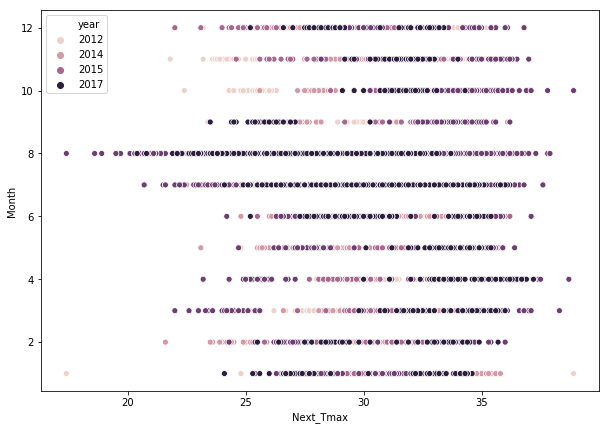

In [24]:
plt.figure(figsize =(10,7))
sns.scatterplot(x = "Next_Tmax",y = "Month", data = temp_ds, hue = "year")

in 8th month min temperature starts from 10 and it didnt score 30 however maximum temperature goes beyond 35.

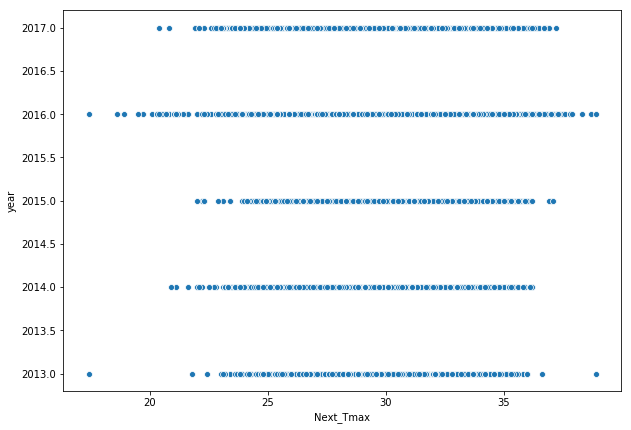

In [25]:
plt.figure(figsize =(10,7))
sns.scatterplot(x = "Next_Tmax",y = "year", data = temp_ds)

1. 2016 temperature went down below 20 and it went beyond 35
2. 2013 to 2015 temperature was above 20 and went beyond 35 and in 2017 as well, it shows same story

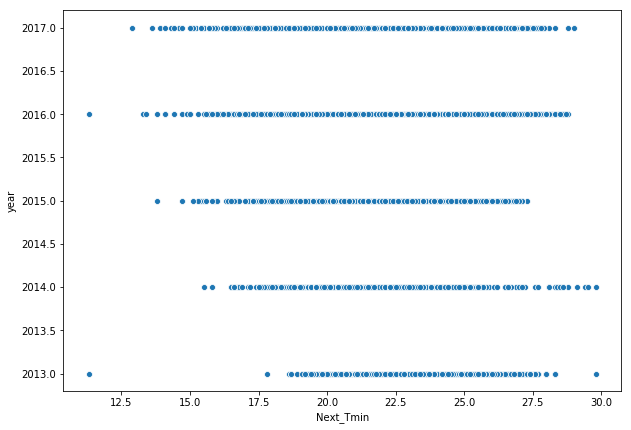

In [26]:
plt.figure(figsize =(10,7))
sns.scatterplot(x = "Next_Tmin",y = "year", data = temp_ds)

1. Most of the points are below 30, in min temperature feature and in 2013 it didnt go below 17.5.
2. in 2017, started from 13 to 14 and went to 28 and 29 max.

In [27]:
temp_ds.groupby("Month")["Present_Tmax","Next_Tmax","Present_Tmin","Next_Tmin"].mean().T

Month,1,2,3,4,5,6,7,8,9,10,11,12
Present_Tmax,30.747090,29.585746,29.433219,30.310946,30.714419,30.013928,29.616070,29.376677,30.803873,29.694819,31.553746,30.224419
Next_Tmax,30.116270,29.986999,30.856700,31.306800,30.995900,30.819666,30.286619,29.832959,30.184999,32.170700,30.718199,29.617600
Present_Tmin,23.218417,23.523800,22.960765,23.310392,23.655501,22.669578,23.606492,22.681719,24.139300,23.619501,23.419400,23.593101
Next_Tmin,23.069841,22.764258,23.047329,23.447200,22.765329,22.662219,23.497280,22.202795,23.326658,23.204129,23.405058,23.125200


In [28]:
temp_ds.groupby("year")["Present_Tmax","Next_Tmax","Present_Tmin","Next_Tmin"].mean().T

year,2013,2014,2015,2016,2017
Present_Tmax,29.727826,29.095376,29.748294,30.740241,29.532269
Next_Tmax,30.150209,29.611919,30.365741,31.251177,29.995548
Present_Tmin,23.992810,22.219968,22.583395,23.835860,23.516952
Next_Tmin,23.700320,21.963376,22.359263,23.495869,23.141282


there is no much difference in  present and Next temperature

In [29]:
pd.set_option("display.max_columns",None)
temp_ds.groupby(["Day","year"])["Present_Tmax","Next_Tmax","Present_Tmin","Next_Tmin"].mean().T

Day                  7                                               \
year               2013       2014       2015       2016       2017   
Present_Tmax  27.809282  30.307000  28.995561  28.868561  29.505713   
Next_Tmax     27.672185  30.730333  29.421667  29.644333  30.230749   
Present_Tmin  22.763216  22.448000  20.944683  21.618750  23.331752   
Next_Tmin     22.396689  22.310333  20.803667  21.354000  23.043656   

Day                  8                                               \
year               2013       2014       2015       2016       2017   
Present_Tmax  31.223364  29.423561  31.827121  33.837349  31.865015   
Next_Tmax     31.811082  29.224250  32.341333  34.676833  32.053250   
Present_Tmin  25.313835  22.783084  24.528167  25.682917  25.074251   
Next_Tmin     25.193989  22.382441  24.079333  25.603548  24.872441   

Day                  13                                            14  \
year               2013    2014       2015    2016       2017    2013   
Present_Tmax  29.263364  27.514  27.406728  31.728  29.739364  29.128   
Next_Tmax     29.488000  27.376  31.587498  31.784  29.967498  31.104   
Present_Tmin  23.902501  22.480  22.383002  24.616  23.516501  24.246   
Next_Tmin     24.108000  21.384  22.250644  25.158  23.992644  24.466   

Day                                                        15          \
year               2014       2015    2016       2017    2013    2014   
Present_Tmax  26.817971  30.997364  31.052  29.505364  30.482  29.808   
Next_Tmax     30.392000  32.797498  31.534  25.765498  30.778  31.098   
Present_Tmin  21.532000  22.412501  25.472  24.208501  24.560  21.900   
Next_Tmin     21.786000  22.604644  24.172  21.784644  25.450  22.082   

Day                                             16                     \
year               2015    2016       2017    2013    2014       2015   
Present_Tmax  32.219364  30.876  25.579364  30.264  30.356  29.059364   
Next_Tmax     29.647498  28.954  27.728000  29.256  27.182  30.691498   
Present_Tmin  22.774501  24.734  22.076501  25.794  22.314  21.502501   
Next_Tmin     20.500644  22.554  21.678000  25.034  22.646  19.474644   

Day                                  17                                        \
year               2016    2017    2013    2014       2015       2016    2017   
Present_Tmax  28.459971  27.250  28.828  26.786  29.975364  28.415971  28.290   
Next_Tmax     29.040000  28.786  29.944  27.278  30.292000  31.138000  30.210   
Present_Tmin  22.716000  21.776  25.136  22.934  19.622820  22.920000  23.262   
Next_Tmin     22.798000  22.378  24.908  20.928  22.930000  23.066000  23.174   

Day                  18                                            19          \
year               2013       2014    2015    2016       2017    2013    2014   
Present_Tmax  29.532728  26.889971  29.512  30.472  29.664728  31.470  27.146   
Next_Tmax     31.900000  27.554000  29.728  32.634  30.978000  31.884  30.320   
Present_Tmin  25.305002  21.086000  23.056  23.206  23.291002  24.318  22.050   
Next_Tmin     23.968000  21.942000  22.284  23.608  23.406000  23.584  22.952   

Day                                       20                                  \
year            2015    2016    2017    2013    2014    2015    2016    2017   
Present_Tmax  29.124  31.972  30.448  31.198  29.684  28.788  33.134  29.466   
Next_Tmax     29.412  33.972  29.860  31.310  28.246  29.166  33.820  30.782   
Present_Tmin  22.412  23.902  23.510  23.804  23.042  23.930  25.322  23.724   
Next_Tmin     23.566  25.172  23.574  24.564  22.454  22.942  25.472  25.108   

Day               21                                         22          \
year            2013    2014    2015    2016       2017    2013    2014   
Present_Tmax  30.832  27.670  28.842  33.254  30.226000  30.912  28.110   
Next_Tmax     31.570  28.574  30.914  34.282  32.203498  27.724  27.388   
Present_Tmin  24.742  22.690  23.130  25.678  25.200000  25.102  22.670   

we dont have any abnormal trend  however in 2016 max temperature went on 34 on 8th and 21st day 

In [30]:
pd.set_option("display.max_columns",None)
temp_ds.groupby("station")["Present_Tmax","Next_Tmax","Present_Tmin","Next_Tmin"].mean().T

station,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0
Present_Tmax,27.047311,29.537742,29.754414,30.141833,29.769927,30.189165,29.662170,29.770778,29.947229,28.876452,30.165616,29.174003,30.258827,29.967977,29.774106,29.020763,29.497419,31.050323,29.624106,29.595601,29.740338,30.342273,30.548387,30.309912,30.470645
Next_Tmax,27.522756,29.996774,30.257419,30.688065,30.202498,30.625160,30.146773,30.300725,30.449677,29.399355,30.635322,29.972822,30.672581,30.452581,30.363386,29.502822,30.009355,31.693871,30.098951,30.029596,30.097742,30.873386,31.087742,30.875403,30.935161
Present_Tmin,21.211256,22.204722,23.440726,23.606210,23.048953,24.034598,23.766452,23.736856,23.118520,22.009664,23.637501,22.229810,23.894355,23.584517,23.358388,22.142574,21.799224,23.974194,22.711071,23.059568,23.832178,23.814436,24.183871,24.267420,24.095806
Next_Tmin,20.891667,21.873548,23.146129,23.296129,22.767616,23.790093,23.497835,23.487731,22.850645,21.670000,23.349885,21.946878,23.633548,23.271290,23.023434,21.808814,21.284516,23.705806,22.362685,22.725588,23.588387,23.533111,23.917742,24.040104,23.855484


1. Station 1 recorded lowest TMAX temperature, rest are all above 29
2. Lowest Next_TMIN temperature was recorded 21 and maximum is 24
3. we have same observation for present TMIN as well

# Feature selection

In [31]:
# checking the variance of the columns whether it will be consant or quasi constant, we will delete the them.
low_variance = {}
for i in temp_ds.iloc[:,2::].columns:
    if temp_ds[i].var() <= 0.01:
        low_variance[i]= temp_ds[i].var()
print(low_variance)

{'lat': 0.0025352758935569104, 'lon': 0.006309936531891838}


We have two columns which low variance and we will delete them. 

In [32]:
temp_ds.drop(columns = ["lat","lon"], axis =1, inplace = True)

In [33]:
temp_ds.head()

,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,LDAPS_CC2,LDAPS_CC3,LDAPS_CC4,LDAPS_PPT1,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin,Day,Month,year
0,1.0,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,0.233947,0.203896,0.161697,0.130928,0.0,0.0,0.0,0.0,212.3350,2.7850,5992.895996,29.1,21.2,30,6,2013
1,2.0,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,0.225508,0.251771,0.159444,0.127727,0.0,0.0,0.0,0.0,44.7624,0.5141,5869.312500,30.5,22.5,30,6,2013
2,3.0,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,0.209344,0.257469,0.204091,0.142125,0.0,0.0,0.0,0.0,33.3068,0.2661,5863.555664,31.1,23.9,30,6,2013
3,4.0,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,0.216372,0.226002,0.161157,0.134249,0.0,0.0,0.0,0.0,45.7160,2.5348,5856.964844,31.7,24.3,30,6,2013
4,5.0,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,0.151407,0.249995,0.178892,0.170021,0.0,0.0,0.0,0.0,35.0380,0.5055,5859.552246,31.2,22.5,30,6,2013


# Correlation plot

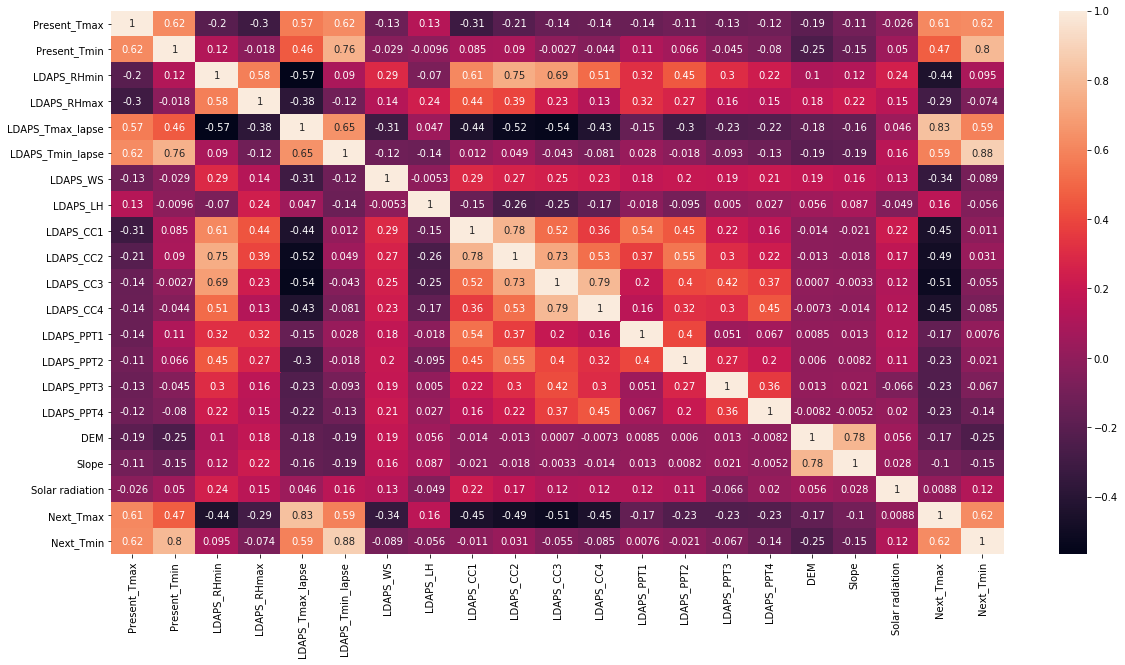

In [34]:
plt.figure(figsize = (20,10))
sns.heatmap(temp_ds.iloc[:,1:-3].corr(), annot = True)

LDAPS_CC2, LDAPS_CC3 are correlated with  LDAPS_CC1, LDAPS_CC4 we will remove them. Present TMIN and LDAPS_Tmin_lase are also correlated but they are expaining good amount of variance towards target columns.so we wont delete them.
tried delete slope as well but after deleting it mean_squared_error is increaing so we will keep it as it is. 

# Model

In [36]:
"""Dropping the these columns, Day, month and year are kept for analysis purpose and 
LDAPS columns are correlated with other columns"""

temp_ds.drop(columns = ["station","Day","Month","year","LDAPS_CC2","LDAPS_CC3"], axis = 1, inplace = True)



In [37]:
# Seprating data into X and Y, since it has two target variance thus kept y1 an y2
X_new = temp_ds.drop(columns =["Next_Tmin","Next_Tmax"], axis=1)
y1_new = temp_ds["Next_Tmin"]
y2_new = temp_ds["Next_Tmax"]

In [38]:
# Next_tmin prediction
for i in range(40,300,60):
    X_train1,X_test1,y1_train,y1_test = train_test_split(X_new,y1_new, test_size =0.2, random_state = i)
    LR1_new = LinearRegression()
    LR1_new.fit(X_train1,y1_train)
    pred= LR1_new.predict(X_test1)
    print("r2score",r2_score(y1_test, pred),"Random",i)
    print("mean_squared_error",mean_squared_error(y1_test, pred),"\n")

r2score 0.8336395173227236 Random 40
mean_squared_error 1.029039371233687 

r2score 0.8364970392521417 Random 100
mean_squared_error 0.9778279664259604 

r2score 0.846122656717333 Random 160
mean_squared_error 0.9942253982510667 

r2score 0.8257861149504455 Random 220
mean_squared_error 1.0541570528172302 

r2score 0.8340537127140065 Random 280
mean_squared_error 1.0432545732735794 



In [39]:
# Next_tmax prediction
for i in range(40,300,60):
    X_train2,X_test2,y2_train,y2_test = train_test_split(X_new,y2_new, test_size =0.2, random_state = i)
    LR2_new = LinearRegression()
    LR2_new.fit(X_train2,y2_train)
    pred= LR2_new.predict(X_test2)
    print("r2score",r2_score(y2_test, pred),"Random",i)
    print("mean_squared_error",mean_squared_error(y2_test, pred),"\n")

r2score 0.7631663397492779 Random 40
mean_squared_error 2.371086120087812 

r2score 0.7582183505955925 Random 100
mean_squared_error 2.354484137695022 

r2score 0.7920785963491335 Random 160
mean_squared_error 2.1560236145894924 

r2score 0.7654085441278897 Random 220
mean_squared_error 2.2174479532920794 

r2score 0.7779133112562898 Random 280
mean_squared_error 2.1159229319240596 



In [40]:
Model1 =  [Lasso() , Ridge(),RandomForestRegressor(),GradientBoostingRegressor(), KNeighborsRegressor(),DecisionTreeRegressor()]
Model2  = [Lasso() , Ridge(),RandomForestRegressor(),GradientBoostingRegressor(), KNeighborsRegressor(),DecisionTreeRegressor()]

In [41]:
# Next_Tmin Prediction
for i in Model1:
    X_train1,X_test1,y1_train,y1_test = train_test_split(X_new,y1_new, test_size =0.2, random_state = 160)
    i.fit(X_train1,y1_train)
    pred= i.predict(X_test1)
    print("r2score",r2_score(y1_test, pred),i)
    print("mean_squared_error",mean_squared_error(y1_test, pred),"\n")

r2score 0.7866226426581977 Lasso()
mean_squared_error 1.3786642240840532 

r2score 0.8461169295104582 Ridge()
mean_squared_error 0.9942624026236042 

r2score 0.9075981975066586 RandomForestRegressor()
mean_squared_error 0.5970223875928262 

r2score 0.888248636501937 GradientBoostingRegressor()
mean_squared_error 0.7220429044896085 

r2score 0.5467882721972409 KNeighborsRegressor()
mean_squared_error 2.92827131632385 

r2score 0.8048014771882045 DecisionTreeRegressor()
mean_squared_error 1.2612079526488542 



In [42]:
# Next_Tmax Prediction
for i in Model2:
    X_train2,X_test2,y2_train,y2_test = train_test_split(X_new,y2_new, test_size =0.2, random_state = 160)
    i.fit(X_train2,y2_train)
    pred= i.predict(X_test2)
    print("r2score",r2_score(y2_test, pred),i)
    print("mean_squared_error",mean_squared_error(y2_test, pred),"\n")

r2score 0.7255823924339013 Lasso()
mean_squared_error 2.8455504425371134 

r2score 0.792064216082238 Ridge()
mean_squared_error 2.15617272956499 

r2score 0.9039316310444026 RandomForestRegressor()
mean_squared_error 0.9961729213369568 

r2score 0.8504664010500094 GradientBoostingRegressor()
mean_squared_error 1.5505761544977466 

r2score 0.5653125161412591 KNeighborsRegressor()
mean_squared_error 4.507455527472477 

r2score 0.7895795995015829 DecisionTreeRegressor()
mean_squared_error 2.1819367535039986 



Randomforest is working good as compared to other models, we will selected Randomforest as final one and train further  

# GridSearchCV

In [43]:
# Next_tmin prediction
RF_y1 = RandomForestRegressor()

para_y1 = {"n_estimators" :[100,150,200,250,300],
          "max_depth" : [2,3,4,5,6,7],
          "min_samples_split" :[2,3,4,5]}

grid_search = GridSearchCV(RF_y1,para_y1, scoring = "r2", cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(X_train1,y1_train)
print(grid_search.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 27.0min finished


{'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 250}


In [44]:
RF_y2 = RandomForestRegressor()

para_y2 = {"n_estimators" :[100.200,250,300],
          "max_depth" : [2,3,4,5,6,7],
          "min_samples_split" :[2,3,4,5]}

grid_search2 = GridSearchCV(RF_y2,para_y2, scoring = "r2", cv = 5, n_jobs = -1, verbose = 2)
grid_search2.fit(X_train2,y2_train)
print(grid_search2.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 15.5min finished


{'max_depth': 7, 'min_samples_split': 3, 'n_estimators': 250}


# Cross_val_score

In [45]:
best_para_RF1 = RandomForestRegressor(max_depth = 7, min_samples_split = 5, n_estimators = 250)

for i in range(2,11):
    cross_score  = cross_val_score(best_para_RF1,X_new, y1_new, scoring = "r2", cv=i)
    print("mean",cross_score.mean()," and sd is", cross_score.std())




mean 0.7751371058539456  and sd is 0.04575912616354766
mean 0.7480331221653455  and sd is 0.06842688232520062
mean 0.7630682840991705  and sd is 0.07461646678150222
mean 0.7527772810715812  and sd is 0.09562188470384313
mean 0.7377808392280206  and sd is 0.0990091390368417
mean 0.7387447894031788  and sd is 0.10254214737241465
mean 0.7444797833024297  and sd is 0.11397901842507831
mean 0.6483204634947235  and sd is 0.20980825820048063
mean 0.7059365647178486  and sd is 0.13504444542498634


CV 6 is giving better score

In [46]:
best_para_RF2 = RandomForestRegressor(max_depth = 7, min_samples_split = 3, n_estimators = 250)

for i in range(2,11):
    cross_score  = cross_val_score(best_para_RF2,X_new, y2_new, scoring = "r2", cv = i)
    print("mean",cross_score.mean()," and sd is", cross_score.std())

mean 0.6684354924201923  and sd is 0.06305831685660557
mean 0.6834430316055154  and sd is 0.07565114471001869
mean 0.6697851182766104  and sd is 0.038878911694669345
mean 0.673793818802886  and sd is 0.059508798548208286
mean 0.6680687583175077  and sd is 0.08234916530539947
mean 0.6717448316464626  and sd is 0.08398948640650913
mean 0.6585331493886294  and sd is 0.05387963376729091
mean 0.5996489087509765  and sd is 0.16105241740227905
mean 0.623300036895096  and sd is 0.13200077479517186


average score for CV 4 is better as compared to other CV

# Model saving 

In [48]:
import pickle 

# training Modelf for Next_tmin
best_para_RF1 = RandomForestRegressor(max_depth = 7, min_samples_split = 5, n_estimators = 300)

best_para_RF1.fit(X_new,y1_new)

# training Modelf for Next_tmax
best_para_RF2 = RandomForestRegressor(max_depth = 7, min_samples_split = 3, n_estimators = 300)

best_para_RF2.fit(X_new,y2_new)

Next_tmin= "Next_Tmin.pkl"
Next_tmax = "Next_Tmax.pkl"


# Saving Next_tmin

with open(Next_tmin, "wb") as f:
    pickle.dump(best_para_RF1,f)


# Saving Next_tmax

with open(Next_tmax, "wb") as f:
    pickle.dump(best_para_RF2,f)




# Conclusion <br> 

We have all numeric data set and basis on that we have to predict Next_Tmin and Tmax temperature.Have checked missing values  and found that all the columns had missing values, it was imputed with mean, even target columns had missing value and imputed with team.i have observed that couple of featureshad outliers whcih corrected with Mean and Std method.
i have checked the variance as well of all the columns to check whether are they constant or quasi constant, i found two features which has variance less than 0.01 so deleted them.we checked the correlation of all the columns except date and station, a few of features were correlated we deleted them and trained Model with many models.

Randomforestregressor is working well out of all other models. it has given 90% r2_score with. I have done further with procesing with Gridsearch CV and cross_val_score and saved the model.
